In [ ]:
from sklearn.metrics import classification_report
import os
from os import mkdir, listdir
from shutil import copyfile, rmtree
from random import sample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths and labels
gdrive_base_path = '/content/drive/My Drive/OA'
train_dir = f'{gdrive_base_path}/TRAIN'
test_dir = f'{gdrive_base_path}/TEST'
validation_dir = f'{gdrive_base_path}/validation'
labels = listdir(train_dir)

# Create validation directory
if 'validation' not in listdir(gdrive_base_path):
    mkdir(validation_dir)
    for label in labels:
        mkdir(f'{validation_dir}/{label}')

# Split training data for validation
for label in labels:
    label_train_path = f'{train_dir}/{label}'
    label_validation_path = f'{validation_dir}/{label}'
    photos = listdir(label_train_path)
    validation_size = len(photos) // 5
    validation_photos = sample(photos, validation_size)

    for photo in validation_photos:
        src = f'{label_train_path}/{photo}'
        dest = f'{label_validation_path}/{photo}'
        copyfile(src, dest)
        os.remove(src)

In [ ]:
# Instancing 'ImageDataGenerator' object
generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [ ]:
pre = InceptionV3(include_top=False,input_shape=(255,255,3))
for layer in pre.layers :
        layer.trainable = False
last_l = pre.get_layer('mixed7')

In [ ]:
last_l.output

<KerasTensor shape=(None, 14, 14, 768), dtype=float32, sparse=False, name=keras_tensor_860>

In [ ]:
#Creating a model by a function.
def Create_model(optm,Loss,acc)->None:
    '''function docstring'''
    # Changed input_shape to (255, 255, 3) to match the data generator's target_size
    pre = InceptionV3(include_top=False,input_shape=(255,255,3))
    for layer in pre.layers :
        layer.trainable = False
    last_l = pre.get_layer('mixed7')
    out = last_l.output
    x = layers.Flatten()(out)
    x = layers.Dense(1024,activation='relu')(x)
    x=layers.Normalization()(x)
    x = layers.Dense(256,activation='relu')(x)
    x=layers.Normalization()(x)
    x = layers.Dense(128,activation='relu')(x)
    x=layers.Normalization()(x)
    x = layers.Dense(64,activation='relu')(x)
    x=layers.Normalization()(x)
    x = layers.Dense(2,activation='softmax')(x)
    model = Model(pre.input,x)
    model.compile(optimizer='adam',loss=Loss, metrics=[acc])

    return model
alg = Create_model(RMSprop(learning_rate=0.0001),'categorical_crossentropy','accuracy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Creating data generators for training and validation
train_generator = generator.flow_from_directory(
    train_dir,
    target_size=(255, 255),
    batch_size=32,
    shuffle=True
)

validation_generator = generator.flow_from_directory(
    validation_dir,
    target_size=(255, 255),
    batch_size=32,
    shuffle=True
)

# Compile the model
alg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = alg.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)


Found 617 images belonging to 2 classes.
Found 882 images belonging to 2 classes.
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 340s 17s/step - accuracy: 0.9188 - loss: 0.2633 - val_accuracy: 0.9286 - val_loss: 0.1605 - learning_rate: 5.0050e-04
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 364s 16s/step - accuracy: 0.9553 - loss: 0.1661 - val_accuracy: 0.9172 - val_loss: 0.2194 - learning_rate: 4.9743e-04
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 381s 19s/step - accuracy: 0.9421 - loss: 0.1706 - val_accuracy: 0.9388 - val_loss: 0.1594 - learning_rate: 4.8828e-04
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 374s 19s/step - accuracy: 0.9521 - loss: 0.1514 - val_accuracy: 0.9399 - val_loss: 0.1580 - learning_rate: 4.7328e-04
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 333s 16s/step - accuracy: 0.9228 - loss: 0.1834 - val_accuracy: 0.9229 - val_loss: 0.2023 - learning_rate: 4.5280e-04


Available keys in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


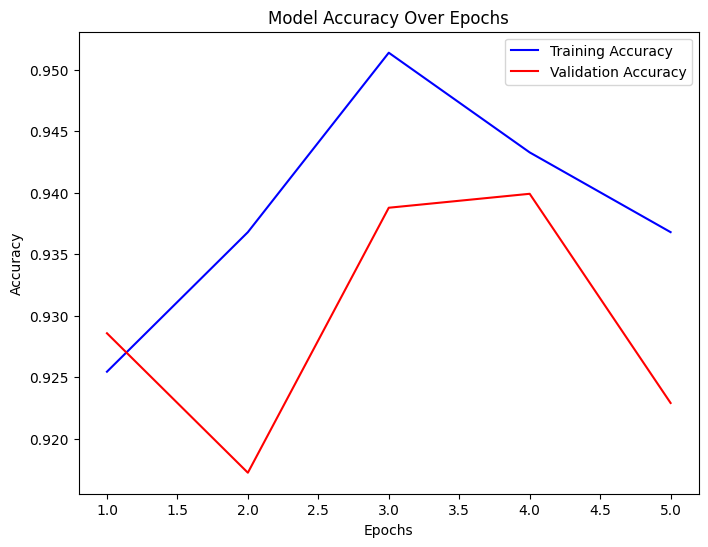

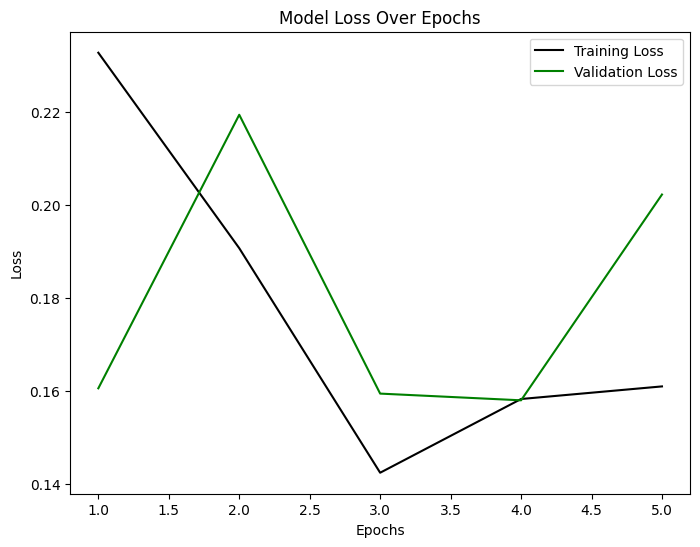

In [ ]:
# Get metrics from history object
results = history.history

# Check available keys to ensure they exist
print("Available keys in history:", results.keys())

# Plot Accuracy
if 'accuracy' in results and 'val_accuracy' in results:
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(results['accuracy']) + 1), results['accuracy'], 'blue', label='Training Accuracy')
    plt.plot(range(1, len(results['val_accuracy']) + 1), results['val_accuracy'], 'red', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()
    plt.show()

# Plot Loss
if 'loss' in results and 'val_loss' in results:
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(results['loss']) + 1), results['loss'], 'black', label='Training Loss')
    plt.plot(range(1, len(results['val_loss']) + 1), results['val_loss'], 'green', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss Over Epochs')
    plt.legend()
    plt.show()


Found 408 images belonging to 2 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.9510 - loss: 0.1470

Evaluation on Test Set:
Loss: 0.1885
Accuracy: 0.9412
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step

Classification Report:
              precision    recall  f1-score   support

      Caries       0.88      0.98      0.93       204
  Gingivitis       0.97      0.87      0.92       204

    accuracy                           0.92       408
   macro avg       0.93      0.92      0.92       408
weighted avg       0.93      0.92      0.92       408



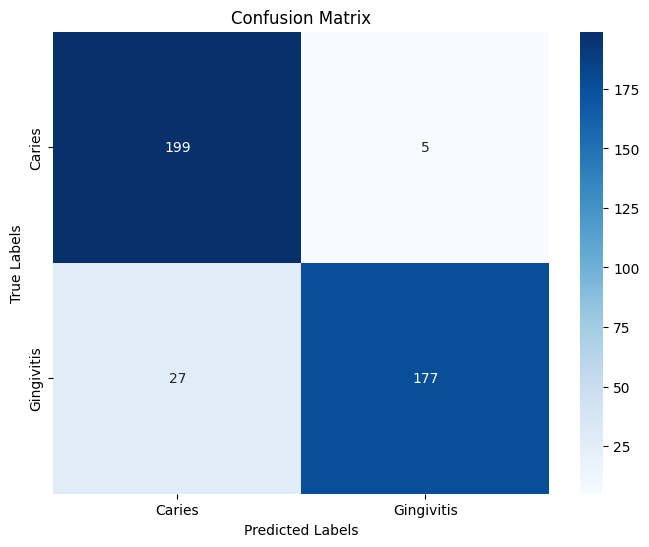

Macro Average Recall: 0.9216
Macro Average Precision: 0.9265


In [ ]:
# Ensure you have a generator for the test set
test_generator = generator.flow_from_directory(
    test_dir,
    target_size=(255, 255),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

# Evaluate the model on the test generator
test_results = alg.evaluate(test_generator, verbose=1)
print("\nEvaluation on Test Set:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")

# Get predictions
predicted_probs = alg.predict(test_generator, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Get true labels from the test generator
true_labels = test_generator.classes

# Generate a classification report
print("\nClassification Report:")
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
import seaborn as sns
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))


# Generate and visualize the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=test_generator.class_indices.keys(),
    yticklabels=test_generator.class_indices.keys()
)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

recall = recall_score(true_labels, predicted_labels, average='macro')
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f"Macro Average Recall: {recall:.4f}")
print(f"Macro Average Precision: {precision:.4f}")


In [ ]:
# Create a test data generator
test_generator = ImageDataGenerator(rescale=1/255)

# Load the test data
ready_test = test_generator.flow_from_directory(
    test_dir,
    target_size=(255, 255),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

# Get the predicted probabilities
predictions = alg.predict(ready_test)

# Convert predicted probabilities to class labels
predicted_labels = predictions.argmax(axis=-1)

true_labels = ready_test.classes

# Generate the classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=ready_test.class_indices.keys()))

# Display the predicted class labels
print("\nPredicted Class Labels:")
print(predicted_labels)


Found 408 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step

Classification Report:
              precision    recall  f1-score   support

      Caries       0.94      0.92      0.93       204
  Gingivitis       0.92      0.94      0.93       204

    accuracy                           0.93       408
   macro avg       0.93      0.93      0.93       408
weighted avg       0.93      0.93      0.93       408


Predicted Class Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [ ]:
ready_test.class_indices

{'Caries': 0, 'Gingivitis': 1}

In [ ]:
dic={num:classes for classes ,num in ready_test.class_indices.items()}

Available Classes: ['Gingivitis', 'Caries']
Randomly Selected Image: /content/drive/My Drive/OA/TEST/Caries/caries_0_2938.jpg


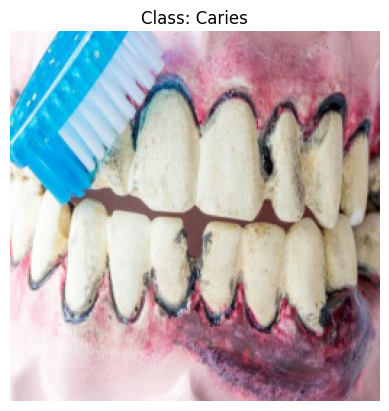

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Predicted Class: Gingivitis

Prediction Probabilities:
Caries: 0.0330
Gingivitis: 0.9670


In [ ]:
# List all subdirectories and randomly pick a class folder
class_folders = [f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))]
print("Available Classes:", class_folders)

# Pick a random image from one of the subfolders
import random

selected_class = random.choice(class_folders)
selected_class_path = os.path.join(test_dir, selected_class)
selected_image = random.choice(os.listdir(selected_class_path))
image_path = os.path.join(selected_class_path, selected_image)

print(f"Randomly Selected Image: {image_path}")

# Load and preprocess the image
img = cv2.imread(image_path)
img = cv2.resize(img, (255, 255))
img = img[..., ::-1] / 255

# Display the image
plt.imshow(img)
plt.title(f"Class: {selected_class}")
plt.axis('off')
plt.show()

# Predict using the model
predictions = alg.predict(img[None])
predicted_class_idx = predictions.argmax(-1)
predicted_class = {v: k for k, v in ready_test.class_indices.items()}[predicted_class_idx[0]]

print(f"Predicted Class: {predicted_class}")

# Display full probability distribution
print("\nPrediction Probabilities:")
for class_name, probability in zip(ready_test.class_indices.keys(), predictions[0]):
    print(f"{class_name}: {probability:.4f}")
